# Multi-Path Effect

<a href="https://rookiepeng.github.io/radarsimpy/" target="_blank" rel="nofollow"><img src="https://img.shields.io/badge/Documentation-latest-brightgree?style=flat&logo=read-the-docs" height="20" align="left"></a>

<br></br>
This is an example of using [`RadarSimPy`](https://github.com/rookiepeng/radarsimpy) to simulate an FMCW radar with a corner reflector model above the ground surface.

---

## Setup FMCW radar

### Transmitter

Setup the basic transmitter parameters through `Transmitter` module.

The following table lists the parameters in this example.

 | Parameter                       | Variable in `Transmitter`| Value                      |
 |---------------------------------|--------------------------|----------------------------|
 | Frequency ($f$)                 | `f`                      | [77e9-50e6, 77e9+50e6] GHz |
 | Time ($T$)                      | `t`                      | 40e-6 s                    |
 | Transmitted power ($P_t$)       | `tx_power`               | 15 dBm                     |
 | Pulse repetition period ($PRP$) | `prp`                    | 100 us                     |
 | Number of pulses                | `pulses`                 | 1                          |

### Receiver

Setup the receiver parameters through `Receiver` module.

The parameters of the receiver are listed in the table below.

 | Parameter                        | Variable in `Receiver`   | Value        |
 |----------------------------------|--------------------------|--------------|
 | Sampling rate ($f_s$)            | `fs`                     | 4 Msps       |
 | Noise figure ($NF$)              | `noise_figure`           | 8 dB         |
 | RF gain/loss ($G_{rf}$)          | `rf_gain`                | 20 dB        |
 | Load resistor ($R_L$)            | `load_resistor`          | 1000 $\Omega$|
 | Baseband voltage gain ($G_{BB}$) | `baseband_gain`          | 80 dB        |

In [1]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

tx_channel = dict(
    location=(0, 0, 0),
)

tx = Transmitter(f=[77e9-50e6, 77e9+50e6],
                 t=40e-6,
                 tx_power=15,
                 prp=100e-6,
                 pulses=1,
                 channels=[tx_channel])


rx_channel = dict(
    location=(0, 0, 0),
)

rx = Receiver(fs=4e6,
              noise_figure=8,
              rf_gain=20,
              load_resistor=1000,
              baseband_gain=80,
              channels=[rx_channel])

radar = Radar(transmitter=tx, receiver=rx, time=np.arange(0, 150, 1))

## Case 1: A corner reflector with ground surface

In [2]:
from radarsimpy.rt import scene
from scipy import signal
import radarsimpy.processing as proc

target_1 = {
    'model': '../models/cr.stl',
    'location': (50, 0, 0),
    'speed': (1, 0, 0)
}

target_2 = {
    'model': '../models/surface_400x400.stl',
    'location': (0, 0, -0.5),
    'speed': (0, 0, 0),
    'is_ground': True
}
targets = [target_1, target_2]

data = scene(radar, targets, density=0.5, noise=False)
baseband = data['baseband']

range_window = signal.chebwin(radar.samples_per_pulse, at=60)
range_profile = proc.cal_range_profile(radar, baseband, range_window)

doppler_window = signal.chebwin(radar.transmitter.pulses, at=60)
range_doppler = proc.cal_range_doppler(
    radar, range_profile, doppler_window, fft_shift=False)

amp_multi = np.max(20*np.log10(np.abs(range_profile)), axis=2)

## Case 2: A corner reflector without ground surface

In [3]:
target_1 = {
    'model': '../models/cr.stl',
    'location': (50, 0, 0),
    'speed': (1, 0, 0)
}

targets = [target_1]

data = scene(radar, targets, density=0.5, noise=False)
baseband = data['baseband']
range_window = signal.chebwin(radar.samples_per_pulse, at=60)
range_profile = proc.cal_range_profile(radar, baseband, range_window)

amp_single = np.max(20*np.log10(np.abs(range_profile)), axis=2)

## Results

Duo to the multi-path:
- Path 1: Tx -> Corner reflecor -> Rx
- Path 2: Tx -> Ground -> Corner reflecor -> Ground -> Rx

A fluctuation can be observed from the received target amplitude versus the target range. 

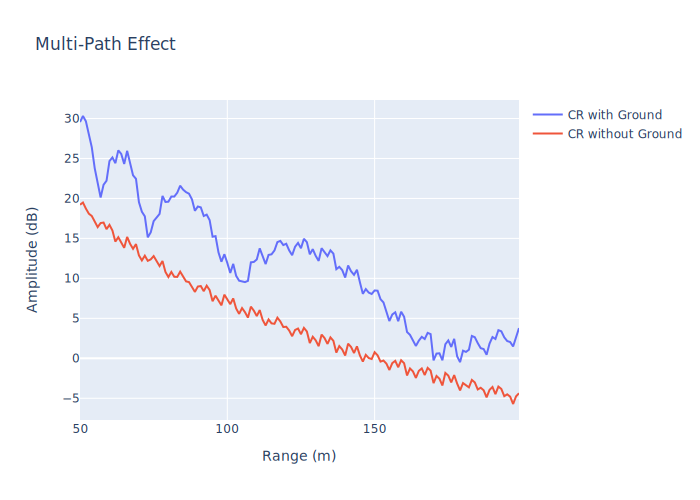

In [4]:
import plotly.graph_objs as go

from IPython.display import SVG, display

t_range = 50+np.arange(0, 150, 1)*1

fig = go.Figure()

fig.add_trace(go.Scatter(x=t_range, y=amp_multi[:, 0],
                         name='CR with Ground'))
fig.add_trace(go.Scatter(x=t_range, y=amp_single[:, 0],
                         name='CR without Ground'))

fig.update_layout(
    title='Multi-Path Effect',
    yaxis=dict(title='Amplitude (dB)'),
    xaxis=dict(title='Range (m)'),
)

# fig.show()
display(SVG(fig.to_image(format='svg', scale=1)))